# Day1課題
car-consumeの線形回帰を行う。

説明を読んだので項目について整理する。
走行毎にデータを取り、燃料のどちらが効率的であるかを出そうとしている。

* distance:走行距離  
* consume:車に表示される100Km当たりの消費燃料
* speed:走行時の平均速度  
* temp_inside:暖房の設定温度、NaNは暖房オフ  
* temp_outside:外気温  
* specials:特筆事項、以下の項目にホットエンコードとして存在している  
* gas_type:燃料の種類  
* AC:エアコンがACモードであるか(?)  
* rain:雨や雪が降っていた  
* sun:よく晴れていた  
* refill liters:給油した量
* refill gas:給油した種類

今回は消費燃料の予測を行う。  
* 関係ありそうなこと  
    - 時速と距離から走行時間が出る。→短いと効率が悪い  
    - 給油のタイミングから車の重量が出そう  
    - 外気温は関係ありそうだが、暖房の設定温度はあんまりなさそう  
    - 設定温度は暖房のオンオフ、外気との差として使うらしい  

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

## 1. データの読み込み 

In [2]:
df_car_consume = pd.read_csv("car-consume/measurements.csv")[['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'specials', 'gas_type', 'AC', 'rain', 'sun', 'refill liters', 'refill gas']]

# データ
display(df_car_consume.head())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [3]:
df_car_consume.describe()

,speed,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,41.927835,11.358247,0.077320,0.123711,0.082474
std,13.598524,6.991542,0.267443,0.329677,0.275441
min,14.000000,-5.000000,0.000000,0.000000,0.000000
25%,32.750000,7.000000,0.000000,0.000000,0.000000
50%,40.500000,10.000000,0.000000,0.000000,0.000000
75%,50.000000,16.000000,0.000000,0.000000,0.000000
max,90.000000,31.000000,1.000000,1.000000,1.000000


## 2. データの整理

* 課題  
 1. describeが一部しか出ない  
 データの形式が怪しい気がする→「,」が含まれている。小数点のつもりのようだ。
 1. 数値でないデータがある  
 ダミー変数を使う

### 2-1. 小数点の整形

In [4]:
# 型確認
print(type(df_car_consume['distance'][0]))

<class 'str'>


In [5]:
# 文字列リプレイス
df_car_consume['distance'] = df_car_consume['distance'].str.replace(',', '.')
df_car_consume['consume'] = df_car_consume['consume'].str.replace(',', '.')
df_car_consume['temp_inside'] = df_car_consume['temp_inside'].str.replace(',', '.')
df_car_consume['refill liters'] = df_car_consume['refill liters'].str.replace(',', '.')
# 数値にする
df_car_consume['distance'] = df_car_consume['distance'].astype(float)
df_car_consume['consume'] = df_car_consume['consume'].astype(float)
df_car_consume['temp_inside'] = df_car_consume['temp_inside'].astype(float)
df_car_consume['refill liters'] = df_car_consume['refill liters'].astype(float)

In [6]:
display(df_car_consume.head())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


In [7]:
df_car_consume.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


describeを表示できた。  

### 2-2.ダミー変数の利用

In [8]:
# ダミーと交換
# df_car_consume['gas_type'] = df_car_consume['gas_type'].map({'E10': 0, 'SP98': 1})
# df_car_consume['specials'] = df_car_consume['specials'].map({'' : 0,'AC rain' : 1,'AC' : 2,'rain' : 3,'snow' : 4,'AC snow' : 5,'half rain half sun' : 6,'sun' : 7,'AC sun' : 8,'sun ac' : 9})
# df_car_consume['refill gas'] = df_car_consume['refill gas'].map({'E10': 0, 'SP98': 1})

# ダミーと交換 ver.2
# カテゴリ値に変換
labels, uniques = pd.factorize(df_car_consume['gas_type'])
df_car_consume['gas_type'] = labels

# この項目はすでに他項目に含まれているため不要
labels, uniques = pd.factorize(df_car_consume['specials'])
df_car_consume['specials'] = labels

# 多分使わない項目
labels, uniques = pd.factorize(df_car_consume['refill gas'])
df_car_consume['refill gas'] = labels

### 2-3.その他コンバート項目

In [9]:
# refill litersの欠損は給油無として0埋め
df_car_consume['refill liters'] = df_car_consume['refill liters'].fillna(0)

# 暖房のオンオフ判断
df_car_consume['heating_off'] = df_car_consume['temp_inside'].isnull().astype(int)

# temp_insideの欠損は暖房がオフのため外部気温と同じとみなしてtemp_outside代入
df_car_consume['temp_inside'] = df_car_consume['temp_inside'].fillna(df_car_consume['temp_outside'])

# 内外の気温差
df_car_consume['temp_diff'] = df_car_consume['temp_inside'] - df_car_consume['temp_outside']

# 燃料の重量
def Calculate_fuel(in_int,Remainning):
    if in_int != 0:
        Remainning = in_int
    else:
        Remainning = Remainning - in_int
    return Remainning



In [10]:
display(df_car_consume.head())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,heating_off,temp_diff
0,28.0,5.0,26,21.5,12,-1,0,0,0,0,45.0,0,0,9.5
1,12.0,4.2,30,21.5,13,-1,0,0,0,0,0.0,-1,0,8.5
2,11.2,5.5,38,21.5,15,-1,0,0,0,0,0.0,-1,0,6.5
3,12.9,3.9,36,21.5,14,-1,0,0,0,0,0.0,-1,0,7.5
4,18.5,4.5,46,21.5,15,-1,0,0,0,0,0.0,-1,0,6.5


変換できた。  
~~今回は列ごとに含まれているものを自分で探したので自動で0から振ってくれる機能があればうれしい。。~~  
→他の人の提出分から真似してver.2にしました。

* 残課題  
  1. ~~給油の種類と給油の量は関係があると思うのでくっつけて一つの項目にしたかった~~
  →関係なし  
  1. ダミーを使うと項目が増えるのと、項目ごとのつながりがなくなって独立してしまう気がしたので使っていない。  
  　使い分けを知りたい  
   →項目内で線形関係がない場合？  
  1. 前回給油量から走行距離*consume/100で出した燃料使用量を説明変数にしたかった  
  →よく考えたら説明変数にconsumeが入ってしまうからだめか。。

## 3. データの分析

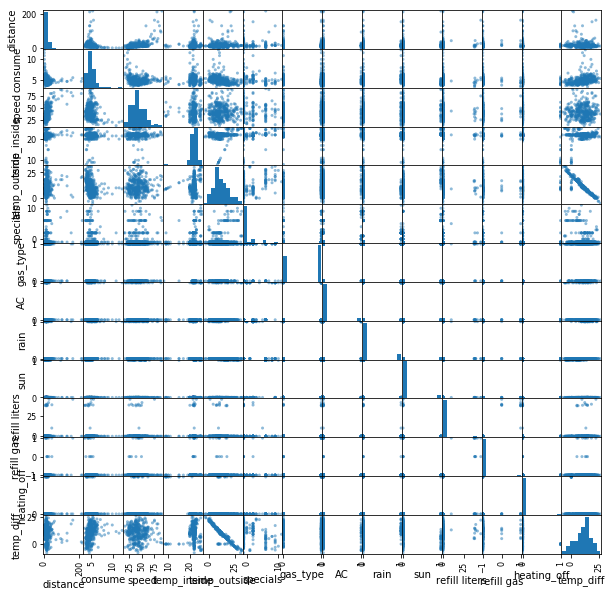

In [11]:
# 散布図行列
pd.plotting.scatter_matrix(df_car_consume, figsize=(10,10))
plt.show()

In [12]:
# 相関係数を確認
df_car_consume.corr()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,heating_off,temp_diff
distance,1.000000,-0.128967,0.562299,0.072861,0.088175,0.108496,-0.053411,-0.025738,-0.019791,0.081120,0.107045,0.108890,-0.035730,-0.066895
consume,-0.128967,1.000000,-0.227866,-0.035716,-0.320811,-0.081323,-0.015327,0.096591,0.248118,-0.170667,-0.074095,-0.083470,-0.069953,0.313642
speed,0.562299,-0.227866,1.000000,0.026292,0.015411,0.061486,-0.097360,-0.035408,0.009489,0.081618,-0.007446,0.015927,-0.012205,-0.007539
temp_inside,0.072861,-0.035716,0.026292,1.000000,0.189519,0.210888,-0.063965,0.182160,-0.010193,0.127052,0.016573,0.015975,-0.820054,0.114541
temp_outside,0.088175,-0.320811,0.015411,0.189519,1.000000,0.330275,0.148705,0.167562,-0.186315,0.346903,-0.041595,-0.044342,0.014287,-0.953707
specials,0.108496,-0.081323,0.061486,0.210888,0.330275,1.000000,0.074513,0.442619,0.250439,0.716271,-0.041553,-0.014103,-0.025738,-0.269564
gas_type,-0.053411,-0.015327,-0.097360,-0.063965,0.148705,0.074513,1.000000,0.105285,0.060328,0.022761,0.000741,0.063026,0.058926,-0.170045
AC,-0.025738,0.096591,-0.035408,0.182160,0.167562,0.442619,0.105285,1.000000,0.242915,0.088598,-0.052571,-0.051534,-0.051715,-0.113738
rain,-0.019791,0.248118,0.009489,-0.010193,-0.186315,0.250439,0.060328,0.242915,1.000000,-0.112650,0.033505,0.061846,-0.021909,0.185383
sun,0.081120,-0.170667,0.081618,0.127052,0.346903,0.716271,0.022761,0.088598,-0.112650,1.000000,-0.054448,-0.053374,0.000558,-0.312066


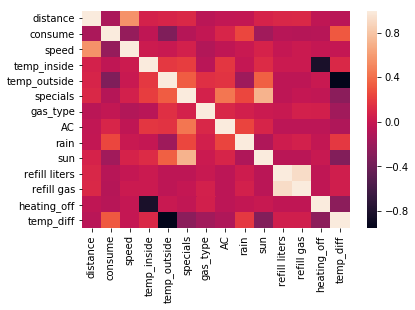

In [13]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_car_consume.corr())
plt.show()

## 4. 学習

以下の説明変数を学習対象から外す。
* temp_inside:暖房の設定温度であり単体ではパフォーマンスに関わらない  
* specials:すでに他項目にホットエンコードとして存在している
* refill liters:単体での走行とは無関係
* refill gas:同上
* temp_diff:外気温に関係が強すぎたため

In [14]:
# 係数を求める
y = df_car_consume["consume"].values
X = df_car_consume[['distance', 'speed', 'temp_outside', 'gas_type', 'AC', 'rain', 'sun', 'heating_off']].values
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
w4 = regr.coef_[3]
w5 = regr.coef_[4]
w6 = regr.coef_[5]
w7 = regr.coef_[6]
w8 = regr.coef_[7]

In [15]:
x1 = df_car_consume['distance'].values
x2 = df_car_consume['speed'].values
x3 = df_car_consume['temp_outside'].values
x4 = df_car_consume['gas_type'].values
x5 = df_car_consume['AC'].values
x6 = df_car_consume['rain'].values
x7 = df_car_consume['sun'].values
x8 = df_car_consume['heating_off'].values

# 重みと二乗誤差の確認
y_est = w0 + w1 * x1 + w2 * x2 + w3 * x3 + w4 * x4 + w5 * x5 + w6 * x6 + w7 * x7 + w8 * x8
squared_error = 0.5 * np.sum((y - y_est) ** 2)
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8))
print('二乗誤差 = {:.3f}'.format(squared_error))

w0 = 6.073, w1 = 0.002, w2 = -0.018, w3 = -0.043, w4 = -0.021, w5 = 0.380, w6 = 0.526, w7 = -0.164, w8 = -0.346
二乗誤差 = 164.135


## 5. モデルの評価

In [16]:
# 値を予測
y_pred = regr.predict(X)

# MSEを計算
mse = mean_squared_error(y, y_pred) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

MSE = 0.846
MAE = 0.616
RMSE = 0.92
